## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [13]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

reduce_lr_factor = [0.1, 0.5]
redice_lr_patient = [10, 25]

In [14]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, optim: %s, reduce_factor: %.2f, reduce_patient: %i" % (i, optim, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=LEARNING_RATE,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, optim: <keras.optimizers.SGD object at 0xb318264e0>, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________________________

50000/50000 [==============================] - 292s 6ms/step - loss: 1.4413 - acc: 0.4949 - val_loss: 1.5623 - val_acc: 0.4521
Epoch 7/10
50000/50000 [==============================] - 266s 5ms/step - loss: 1.4029 - acc: 0.5108 - val_loss: 1.5338 - val_acc: 0.4588
Epoch 8/10
50000/50000 [==============================] - 240s 5ms/step - loss: 1.3687 - acc: 0.5218 - val_loss: 1.5273 - val_acc: 0.4630
Epoch 9/10
50000/50000 [==============================] - 268s 5ms/step - loss: 1.3371 - acc: 0.5343 - val_loss: 1.5086 - val_acc: 0.4684
Epoch 10/10
50000/50000 [==============================] - 271s 5ms/step - loss: 1.3083 - acc: 0.5449 - val_loss: 1.4987 - val_acc: 0.4739
Numbers of exp: 3, optim: <keras.optimizers.SGD object at 0xb318264e0>, reduce_factor: 0.50, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
__________

50000/50000 [==============================] - 241s 5ms/step - loss: 1.7904 - acc: 0.3719 - val_loss: 1.8287 - val_acc: 0.3800
Epoch 2/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.5409 - acc: 0.4521 - val_loss: 1.6299 - val_acc: 0.4215
Epoch 3/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.4497 - acc: 0.4861 - val_loss: 1.5418 - val_acc: 0.4538
Epoch 4/10
50000/50000 [==============================] - 234s 5ms/step - loss: 1.3894 - acc: 0.5064 - val_loss: 1.6188 - val_acc: 0.4214
Epoch 5/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.3263 - acc: 0.5278 - val_loss: 1.5128 - val_acc: 0.4529
Epoch 6/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.2760 - acc: 0.5476 - val_loss: 1.5025 - val_acc: 0.4670
Epoch 7/10
50000/50000 [==============================] - 236s 5ms/step - loss: 1.2340 - acc: 0.5653 - val_loss: 1.6197 - val_acc: 0.4248
Epoch 8/10
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 240s 5ms/step - loss: 1.8092 - acc: 0.3712 - val_loss: 1.9399 - val_acc: 0.3485
Epoch 2/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.5345 - acc: 0.4571 - val_loss: 3.0586 - val_acc: 0.2232
Epoch 3/10
50000/50000 [==============================] - 234s 5ms/step - loss: 1.4358 - acc: 0.4910 - val_loss: 2.4348 - val_acc: 0.2504
Epoch 4/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.3659 - acc: 0.5163 - val_loss: 2.5541 - val_acc: 0.2393
Epoch 5/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.3036 - acc: 0.5365 - val_loss: 2.6526 - val_acc: 0.2393
Epoch 6/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.2510 - acc: 0.5578 - val_loss: 1.9648 - val_acc: 0.3202
Epoch 7/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.1940 - acc: 0.5796 - val_loss: 1.8817 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 242s 5ms/step - loss: 1.8088 - acc: 0.3732 - val_loss: 2.2191 - val_acc: 0.3098
Epoch 2/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.5389 - acc: 0.4564 - val_loss: 2.1291 - val_acc: 0.2857
Epoch 3/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.4354 - acc: 0.4938 - val_loss: 2.3116 - val_acc: 0.2622
Epoch 4/10
50000/50000 [==============================] - 234s 5ms/step - loss: 1.3589 - acc: 0.5186 - val_loss: 2.1111 - val_acc: 0.3135
Epoch 5/10
50000/50000 [==============================] - 234s 5ms/step - loss: 1.2937 - acc: 0.5435 - val_loss: 2.4215 - val_acc: 0.2861
Epoch 6/10
50000/50000 [==============================] - 233s 5ms/step - loss: 1.2428 - acc: 0.5619 - val_loss: 1.6754 - val_acc: 0.4095
Epoch 7/10
50000/50000 [==============================] - 235s 5ms/step - loss: 1.1965 - acc: 0.5779 - val_loss: 2.0068 - 

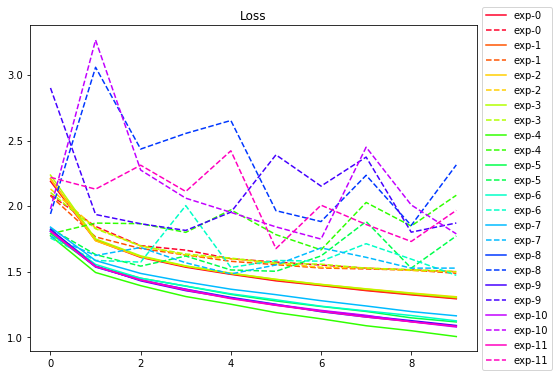

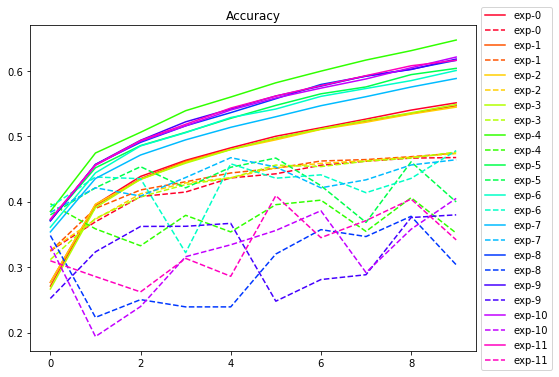

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()